# Deep Convolutional Generative Adversarial Networks with TensorFlow

 In this tutorial, we will try to build a GAN that is able to generate human faces with TensorFlow. Sounds scary, doesn’t it?


## Setup

A helper function will automatically download the CelebA dataset to get you up and running quickly. Be sure to have matplotlib installed to actually see the images.

In [1]:
import helper

data_dir = './data'
# Let's download the dataset
helper.download_celeb_a()

[*] ./data/img_align_celeba.zip already exists


## The CelebA Dataset

The CelebFaces Attributes Dataset dataset contains over 200,000 celebrity images each with 40 attribute annotations. At this point, we are also going to define to function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. To get some better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their values are in a range from -0,5 to +0,5. At last, we are going to downscale the images to 28x28 after that.

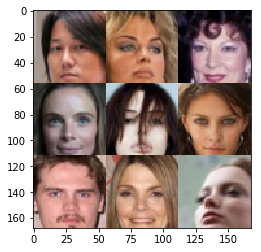

In [2]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image, ImageFile
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        

test_images = get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images))

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. We are doing this to not clutter the training function any more than it already is. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [3]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

## The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [4]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        # Conv 4
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 1, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
       
        # Flatten
        flat = tf.reshape(lrelu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

## The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 3, 1, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, 2, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out

## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [6]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

## Optimization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [8]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(helper.images_square_grid(samples))
    pyplot.show()

## Training

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 200 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady - and we mean slowly but steady! This progress can take up some hours based on your setup.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 300 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])


Epoch 1/5... Discriminator Loss: 0.7593... Generator Loss: 2.2315


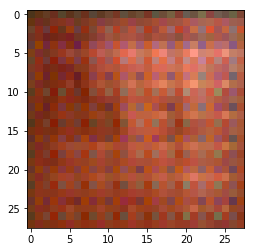

Epoch 1/5... Discriminator Loss: 1.1341... Generator Loss: 0.9175


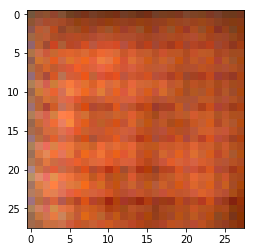

Epoch 1/5... Discriminator Loss: 1.5480... Generator Loss: 0.4633


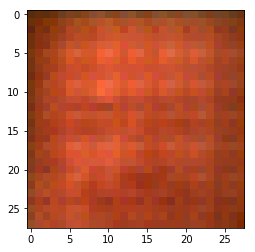

Epoch 1/5... Discriminator Loss: 2.1229... Generator Loss: 0.2404


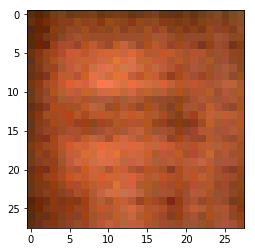

Epoch 1/5... Discriminator Loss: 1.1469... Generator Loss: 0.7108


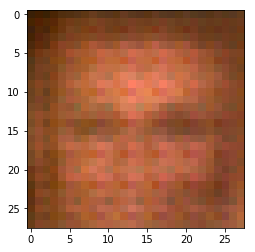

Epoch 1/5... Discriminator Loss: 1.0496... Generator Loss: 1.8533


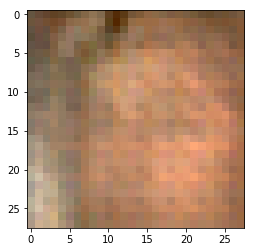

Epoch 1/5... Discriminator Loss: 1.2289... Generator Loss: 0.8737


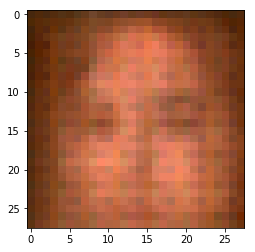

Epoch 1/5... Discriminator Loss: 1.9669... Generator Loss: 0.2819


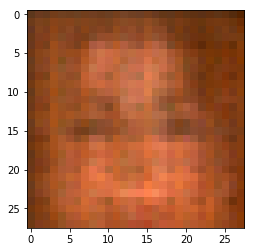

Epoch 1/5... Discriminator Loss: 1.5139... Generator Loss: 2.5717


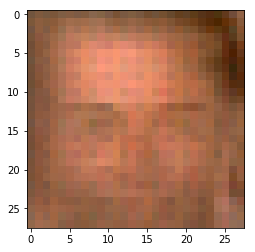

Epoch 1/5... Discriminator Loss: 2.0191... Generator Loss: 0.2868


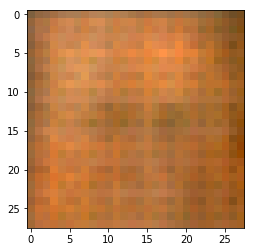

Epoch 1/5... Discriminator Loss: 1.1439... Generator Loss: 0.9880


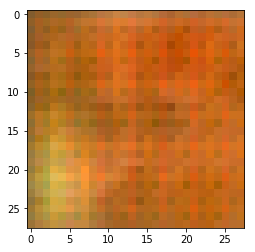

Epoch 1/5... Discriminator Loss: 1.1897... Generator Loss: 0.7655


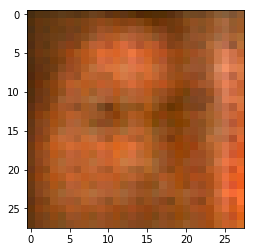

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 5

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)